In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings("ignore")

In [4]:
# Importing data
company_data_df = pd.read_csv(r"Company_Data.csv")

In [5]:
company_data_df

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No
...,...,...,...,...,...,...,...,...,...,...,...
395,12.57,138,108,17,203,128,Good,33,14,Yes,Yes
396,6.14,139,23,3,37,120,Medium,55,11,No,Yes
397,7.41,162,26,12,368,159,Medium,40,18,Yes,Yes
398,5.94,100,79,7,284,95,Bad,50,12,Yes,Yes


In [6]:
company_data_df.shape

(400, 11)

In [7]:
# Checking datatypes
company_data_df.dtypes

Sales          float64
CompPrice        int64
Income           int64
Advertising      int64
Population       int64
Price            int64
ShelveLoc       object
Age              int64
Education        int64
Urban           object
US              object
dtype: object

In [8]:
# Checking dupliacte values
company_data_df[company_data_df.duplicated()]

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US


In [9]:
# Finding Missing Values
nan_bool_df = company_data_df.isna()

# Use sum() to count the number of True values (NaN) in each column
nan_count_per_column = nan_bool_df.sum()

# If you want the total count of NaN values in the entire DataFrame, you can sum the nan_count_per_column
total_nan_count = nan_count_per_column.sum()

nan_count_per_column

total_nan_count

0

In [10]:
company_data_df.describe()

,Sales,CompPrice,Income,Advertising,Population,Price,Age,Education
count,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000
mean,7.496325,124.975000,68.657500,6.635000,264.840000,115.795000,53.322500,13.900000
std,2.824115,15.334512,27.986037,6.650364,147.376436,23.676664,16.200297,2.620528
min,0.000000,77.000000,21.000000,0.000000,10.000000,24.000000,25.000000,10.000000
25%,5.390000,115.000000,42.750000,0.000000,139.000000,100.000000,39.750000,12.000000
50%,7.490000,125.000000,69.000000,5.000000,272.000000,117.000000,54.500000,14.000000
75%,9.320000,135.000000,91.000000,12.000000,398.500000,131.000000,66.000000,16.000000
max,16.270000,175.000000,120.000000,29.000000,509.000000,191.000000,80.000000,18.000000


### In the next step the dataframe is split into two dataframes namely continuous variable dataframe and categorical variable dataframe.
### Continuous variable dataframe will be checked for multicollinearity and kind of distribution each variable has. Based on the distribution either normalization or the standardization will be applied.
### Categorical variable dataframe will undergo one hot encoder and label encoder for the categorical variables.
### These dataframes will be mearged after these pre processing steps.
## Splitting of dataframe. 

In [12]:
# Dataframe to check the outliers for the continuous variable.

cont_df = company_data_df[['CompPrice', 'Income', 'Advertising', 'Population', 'Price', 'Age', 'Education']]
cat_df = company_data_df[['Urban', 'US', 'ShelveLoc', 'Sales']]

### Pre-processing of training continuous variable dataframe.

In [13]:
cont_df

,CompPrice,Income,Advertising,Population,Price,Age,Education
0,138,73,11,276,120,42,17
1,111,48,16,260,83,65,10
2,113,35,10,269,80,59,12
3,117,100,4,466,97,55,14
4,141,64,3,340,128,38,13
...,...,...,...,...,...,...,...
395,138,108,17,203,128,33,14
396,139,23,3,37,120,55,11
397,162,26,12,368,159,40,18
398,100,79,7,284,95,50,12


### Using Box Plot to detect the outliers

Indices of outliers from the box plots:
[165, 42, 174, 367, 310, 125]
6


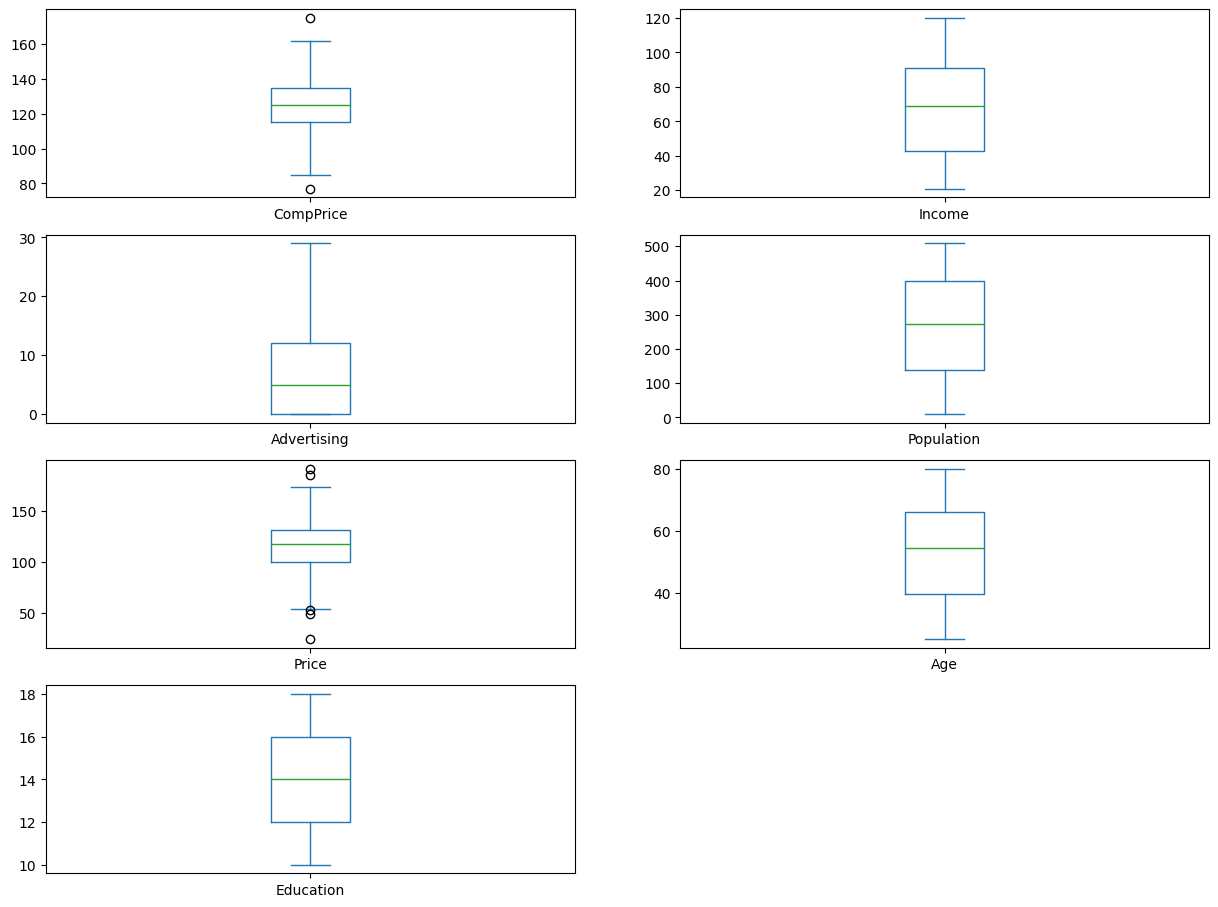

In [15]:
# Box plot find the outliers 

box_plot = cont_df.plot(kind="box",subplots=True,layout=(7,2),figsize=(15,20));

# Calculate the IQR for each variable
Q1 = cont_df.quantile(0.25)
Q3 = cont_df.quantile(0.75)
IQR = Q3 - Q1

# Set the IQR multiplier for identifying potential outliers
IQR_multiplier = 1.5  # Adjust as needed

# Get the indices of the outliers
outlier_indices = []

for col, ax in zip(cont_df.columns, box_plot):
    outliers = ((cont_df[col] < (Q1[col] - IQR_multiplier * IQR[col])) | (cont_df[col] > (Q3[col] + IQR_multiplier * IQR[col])))
    col_outlier_indices = cont_df.index[outliers]
    outlier_indices.extend(col_outlier_indices)

outlier_indices = list(set(outlier_indices))  # Remove duplicate indices

# Display the outlier indices
print("Indices of outliers from the box plots:")
print(outlier_indices)
print(len(outlier_indices))

### Using IQR to detect the outliers

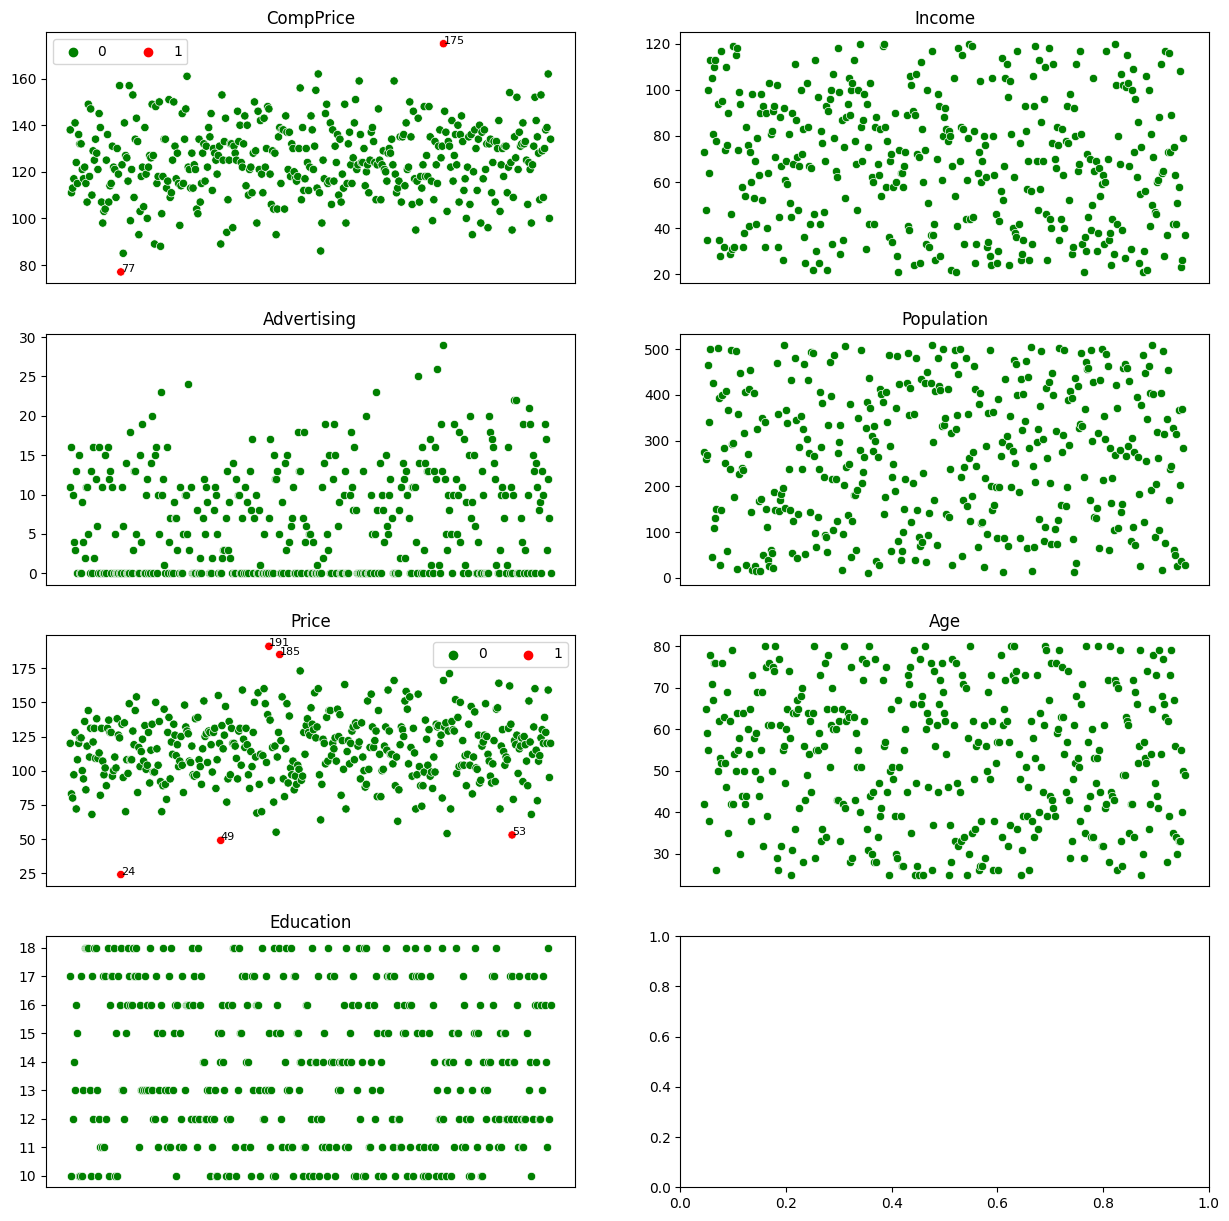

Row indices of potential outliers:
Int64Index([42, 125, 165, 174, 310, 367], dtype='int64')


In [19]:
#FUNCTION TO IDENTIFY OUTLIERS USING IQR METHOD
def iqr_outlier(x,factor):
    q1 = x.quantile(0.25)
    q3 = x.quantile(0.75)
    iqr = q3 - q1
    min_ = q1 - factor * iqr
    max_ = q3 + factor * iqr
    result_ = pd.Series([0] * len(x))
    result_[((x < min_) | (x > max_))] = 1
    return result_
#SCATTER PLOTS HIGHLIGHTING OUTLIERS CALCULATED USING IQR METHOD
fig, ax = plt.subplots(4, 2, figsize=(15, 15))
row = col = 0
for n,i in enumerate(cont_df.columns):
    if (n % 2 == 0) & (n > 0):
        row += 1
        col = 0
    outliers = iqr_outlier(cont_df[i], 1.5)
   
   
    if sum(outliers) == 0:
        sns.scatterplot(x = np.arange(len(cont_df[i])), y = cont_df[i], ax = ax[row, col], legend=False, color = 'green')
    else:
        sns.scatterplot(x = np.arange(len(cont_df[i])), y = cont_df[i], ax = ax[row, col], hue = outliers, palette = ['green','red'])
    for x,y in zip(np.arange(len(cont_df[i]))[outliers == 1], cont_df[i][outliers == 1]):
        ax[row,col].text(x = x, y = y, s = y, fontsize = 8)
    ax[row,col].set_ylabel("")
    ax[row,col].set_title(i)
    ax[row,col].xaxis.set_visible(False)
    if sum(outliers) > 0:
        ax[row,col].legend(ncol=2)
    col += 1
plt.show()

# Calculate the IQR for each variable
Q1 = cont_df.quantile(0.25)
Q3 = cont_df.quantile(0.75)
IQR = Q3 - Q1

# Set the IQR multiplier for identifying potential outliers
IQR_multiplier = 1.5  # Adjust as needed

# Identify potential outliers based on the IQR method
outliers = ((cont_df < (Q1 - IQR_multiplier * IQR)) | (cont_df > (Q3 + IQR_multiplier * IQR)))

# Get the row indices of potential outliers
row_indices = cont_df.index[outliers.any(axis=1)]

# Print the row indices of potential outliers
print("Row indices of potential outliers:")
print(row_indices)

### Using Z-Scores to detect the outliers

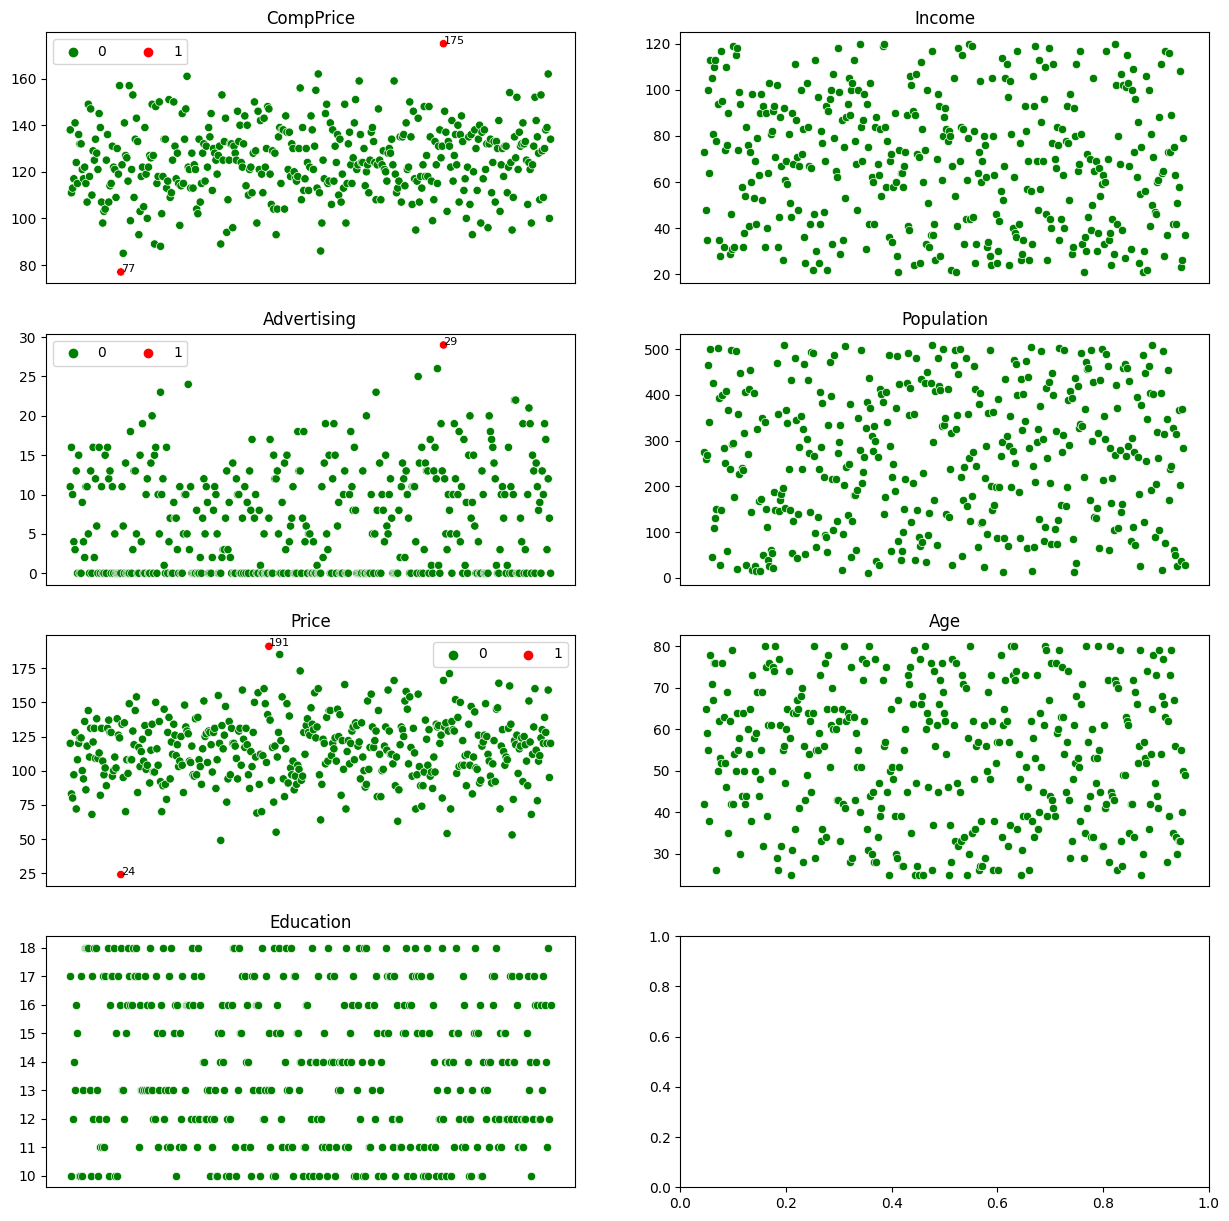

In [21]:
#FUNCTION TO DETECT OUTLIERS USING Z-SCORE METHOD
def zscore_outlier(x,lb,ub):
    zscore = ((x - x.mean()) / x.std()).copy()
    result_ = pd.Series([0] * len(x))
    result_[((zscore < lb) | (zscore > ub))] = 1
    return result_
#PLOTTING A SCATTER PLOT AND HIGHLIGHTING THE OUTLIERS DETECTED BY Z-SCORE METHOD
fig, ax = plt.subplots(4, 2, figsize=(15, 15))
row = col = 0
for n,i in enumerate(cont_df.columns):
    if (n % 2 == 0) & (n > 0):
        row += 1
        col = 0
    outliers = zscore_outlier(cont_df[i], -3, 3)
   
    if sum(outliers) == 0:
        sns.scatterplot(x = np.arange(len(cont_df[i])), y = cont_df[i], ax = ax[row, col], legend=False, color = 'green')
    else:
        sns.scatterplot(x = np.arange(len(cont_df[i])), y = cont_df[i], ax = ax[row, col], hue = outliers, palette = ['green','red'])
    for x,y in zip(np.arange(len(cont_df[i]))[outliers == 1], cont_df[i][outliers == 1]):
        ax[row,col].text(x = x, y = y, s = y, fontsize = 8)
    ax[row,col].set_ylabel("")
    ax[row,col].set_title(i)
    ax[row,col].xaxis.set_visible(False)
    if sum(outliers) > 0:
        ax[row,col].legend(ncol=2)
    col += 1

plt.show()


### Calculating the range for the continuous variable to check the outliers.

In [22]:
cont_df.describe()

,CompPrice,Income,Advertising,Population,Price,Age,Education
count,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000
mean,124.975000,68.657500,6.635000,264.840000,115.795000,53.322500,13.900000
std,15.334512,27.986037,6.650364,147.376436,23.676664,16.200297,2.620528
min,77.000000,21.000000,0.000000,10.000000,24.000000,25.000000,10.000000
25%,115.000000,42.750000,0.000000,139.000000,100.000000,39.750000,12.000000
50%,125.000000,69.000000,5.000000,272.000000,117.000000,54.500000,14.000000
75%,135.000000,91.000000,12.000000,398.500000,131.000000,66.000000,16.000000
max,175.000000,120.000000,29.000000,509.000000,191.000000,80.000000,18.000000


#### Even though the outlier methods shows so many records as outliers, it is important to consider the domain knowleage to treat or change any records in the dataset.

#### We need to carefully consider each feature and we need to treat the outliers accordling.

#### 1. Feature CompPrice has some outliers which is not in the reasonable range for the dataset. Hence we need to treat this outlier. But none of the record is negative. Hence each record is valueable record.

#### 2. Feature Income has outliers but none of the value is negative. The values range from 21 to 120 which is a reasonable range for the dataset. Hence no outlier treatment is required.

#### 3. Feature Advertising has some outliers which is not in the reasonable range for the dataset. Hence we need to treat this outlier. But none of the record is negative. Hence each record is valueable record.

#### 4. Feature Population has outliers but none of the value is negative. The values range from 10 to 509 which is a reasonable range for the dataset. Hence no outlier treatment is required

#### 5. Feature Price has outliers but none of the value is negative. The values range from 24 to 191 which is a reasonable range for the dataset. Hence no outlier treatment is required. 

#### 6. Feature Age has outliers but none of the value is negative. The values range from 25 to 80 which is a reasonable range for the dataset. Hence no outlier treatment is required. 

#### 7. Feature Education has outliers but none of the value is negative. The values range from 10 to 18 which is a reasonable range for the dataset. Hence no outlier treatment is required. 

In [23]:
# Create a copy of the DataFrame
cont_df2 = cont_df.copy()

### Manually finding the extreme outliers and replacing with the median value.

In [24]:
# Filter DataFrame to find records where previous duration is greater than the threshold
record1 = cont_df2[(cont_df2["CompPrice"] <= 70) | (cont_df2["CompPrice"] >= 160)]
record2 = cont_df2[(cont_df2["Price"] <= 50) | (cont_df2["Price"] >= 175)]
print(record1, record2)

     CompPrice  Income  Advertising  Population  Price  Age  Education
97         161      82            5         287    129   33         16
206        162      67            0          27    160   77         17
310        175      65           29         419    166   53         12
397        162      26           12         368    159   40         18      CompPrice  Income  Advertising  Population  Price  Age  Education
42          77      69            0          25     24   50         18
125         89      78            0         181     49   43         15
165        147      58            7         100    191   27         15
174        139      24            0         358    185   79         15


In [26]:
import pandas as pd

# Create lists of indices from the filtered records
indices_record1 = record1.index.tolist()
indices_record2 = record2.index.tolist()

# Calculate the median values for the columns used for filtering
median_comprice = cont_df2["CompPrice"].median()
median_price = cont_df2["Price"].median()

# Replace values in the original DataFrame at specified indices with the respective median values
cont_df2.loc[indices_record1, "CompPrice"] = median_comprice
cont_df2.loc[indices_record2, "Price"] = median_price


In [27]:
# Filter DataFrame to find records where previous duration is greater than the threshold
record1 = cont_df2[(cont_df2["CompPrice"] <= 70) | (cont_df2["CompPrice"] >= 160)]
record2 = cont_df2[(cont_df2["Price"] <= 50) | (cont_df2["Price"] >= 175)]
print(record1, record2)

Empty DataFrame
Columns: [CompPrice, Income, Advertising, Population, Price, Age, Education]
Index: [] Empty DataFrame
Columns: [CompPrice, Income, Advertising, Population, Price, Age, Education]
Index: []


In [28]:
cont_df2

,CompPrice,Income,Advertising,Population,Price,Age,Education
0,138,73,11,276,120,42,17
1,111,48,16,260,83,65,10
2,113,35,10,269,80,59,12
3,117,100,4,466,97,55,14
4,141,64,3,340,128,38,13
...,...,...,...,...,...,...,...
395,138,108,17,203,128,33,14
396,139,23,3,37,120,55,11
397,125,26,12,368,159,40,18
398,100,79,7,284,95,50,12


### Calculating the range for the continuous variable after outlier treatment.

In [29]:
cont_df2.describe()

,CompPrice,Income,Advertising,Population,Price,Age,Education
count,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000
mean,124.575000,68.657500,6.635000,264.840000,115.842500,53.322500,13.900000
std,14.784818,27.986037,6.650364,147.376436,22.407989,16.200297,2.620528
min,77.000000,21.000000,0.000000,10.000000,53.000000,25.000000,10.000000
25%,115.000000,42.750000,0.000000,139.000000,100.750000,39.750000,12.000000
50%,125.000000,69.000000,5.000000,272.000000,117.000000,54.500000,14.000000
75%,134.250000,91.000000,12.000000,398.500000,131.000000,66.000000,16.000000
max,159.000000,120.000000,29.000000,509.000000,173.000000,80.000000,18.000000


### Box plot after outlier treatment.¶

Indices of outliers from the box plots:
[42, 171, 44, 367, 208, 313]
6


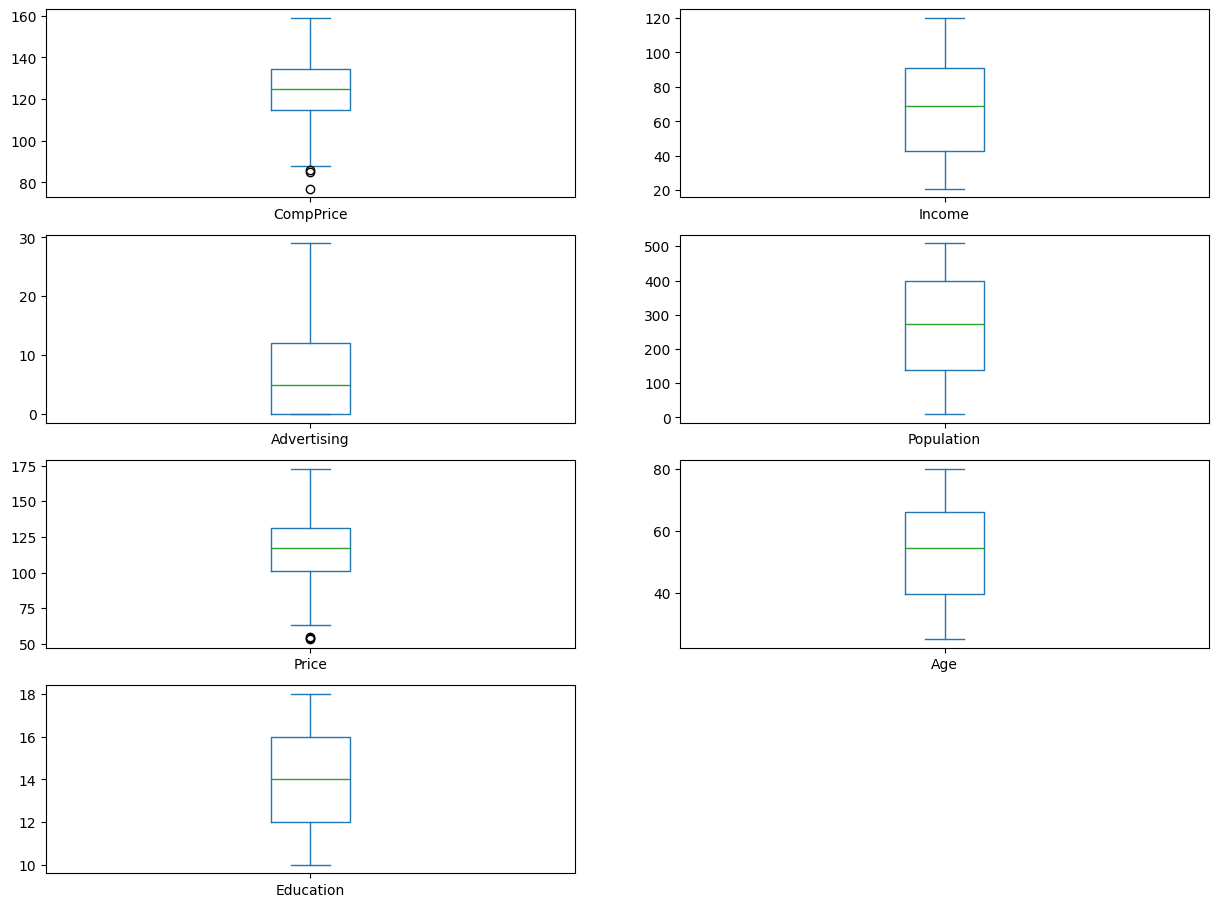

In [30]:
# Box plot find the outliers 

box_plot = cont_df2.plot(kind="box",subplots=True,layout=(7,2),figsize=(15,20));

# Calculate the IQR for each variable
Q1 = cont_df2.quantile(0.25)
Q3 = cont_df2.quantile(0.75)
IQR = Q3 - Q1

# Set the IQR multiplier for identifying potential outliers
IQR_multiplier = 1.5  # Adjust as needed

# Get the indices of the outliers
outlier_indices = []

for col, ax in zip(cont_df2.columns, box_plot):
    outliers = ((cont_df2[col] < (Q1[col] - IQR_multiplier * IQR[col])) | (cont_df2[col] > (Q3[col] + IQR_multiplier * IQR[col])))
    col_outlier_indices = cont_df2.index[outliers]
    outlier_indices.extend(col_outlier_indices)

outlier_indices = list(set(outlier_indices))  # Remove duplicate indices

# Display the outlier indices
print("Indices of outliers from the box plots:")
print(outlier_indices)
print(len(outlier_indices))

In [31]:
# Correlation matrix to check the multi collinearity of the features
cont_df2.corr()

,CompPrice,Income,Advertising,Population,Price,Age,Education
CompPrice,1.000000,-0.075522,-0.050904,-0.102279,0.522137,-0.100151,0.010156
Income,-0.075522,1.000000,0.058995,-0.007877,-0.041954,-0.004670,-0.056855
Advertising,-0.050904,0.058995,1.000000,0.265652,0.036226,-0.004557,-0.033594
Population,-0.102279,-0.007877,0.265652,1.000000,-0.029636,-0.042663,-0.106378
Price,0.522137,-0.041954,0.036226,-0.029636,1.000000,-0.113548,0.025212
Age,-0.100151,-0.004670,-0.004557,-0.042663,-0.113548,1.000000,0.006488
Education,0.010156,-0.056855,-0.033594,-0.106378,0.025212,0.006488,1.000000


<AxesSubplot: >

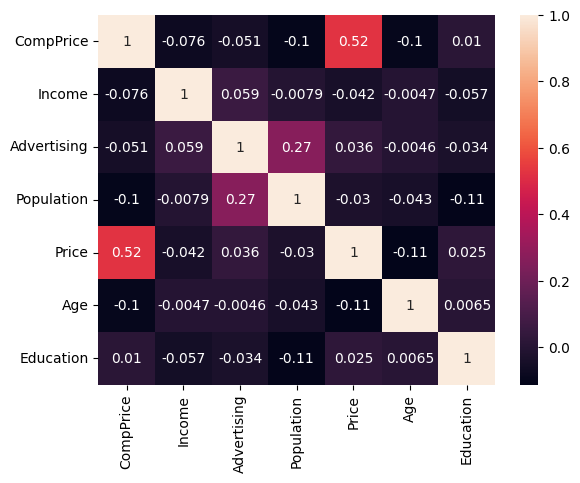

In [32]:
# Heatmaps for the given dataset.
sns.heatmap(cont_df2.corr(), annot=True)

### None of the value is near or equal to 1 or -1 for the continuous features. Hence no multicolinearity present.

In [33]:
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calculate VIF for each feature
def calculate_vif(data_frame):
    vif_data = pd.DataFrame()
    vif_data["feature"] = data_frame.columns
    vif_data["VIF"] = [variance_inflation_factor(data_frame.values, i) for i in range(data_frame.shape[1])]
    return vif_data

vif_results = calculate_vif(cont_df2)  
print("VIF Results:")
print(vif_results)

VIF Results:
       feature        VIF
0    CompPrice  61.322760
1       Income   6.515859
2  Advertising   2.166178
3   Population   4.313448
4        Price  38.396887
5          Age  10.434471
6    Education  22.881758


### VIF value for all the features is very low. Hence all the variables are significant and there is no presence of multicollinearity.

### From both the correlation matrix and the VIF value show that none of the feature depend on each other. Hence there is no multicollinearity present in the dataset. 

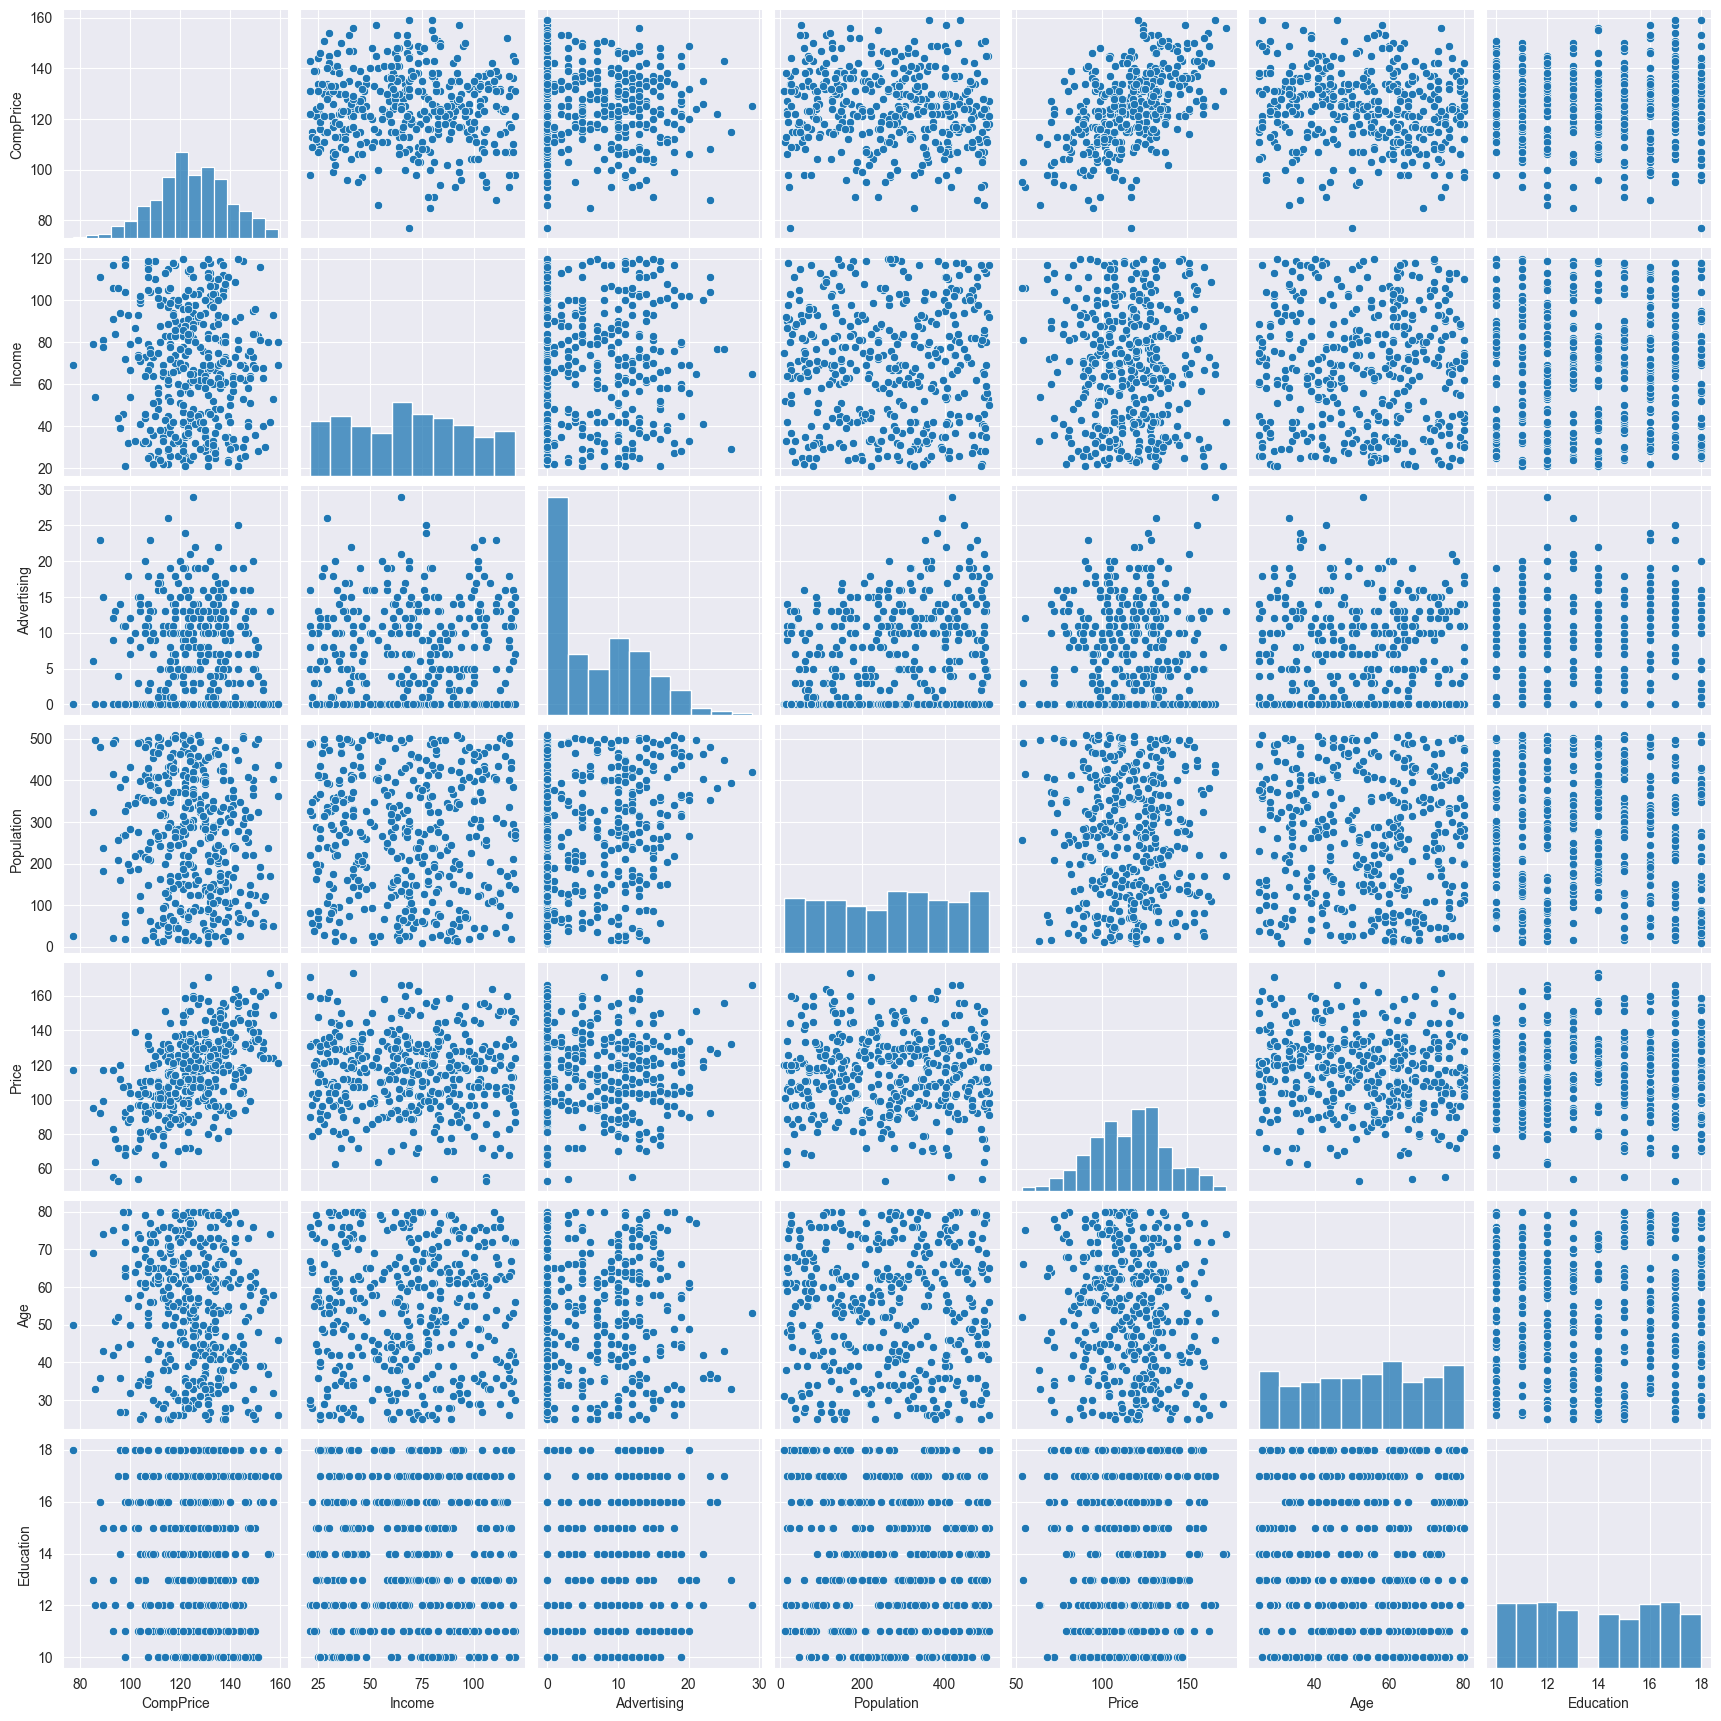

In [34]:
# Drawing Histogram to check the distribution of the data.
#Format the plot background and scatter plots for all the variables
sns.set_style(style='darkgrid')
sns.pairplot(cont_df2)

### Most of the histogram shows that the features are not normally distributed.

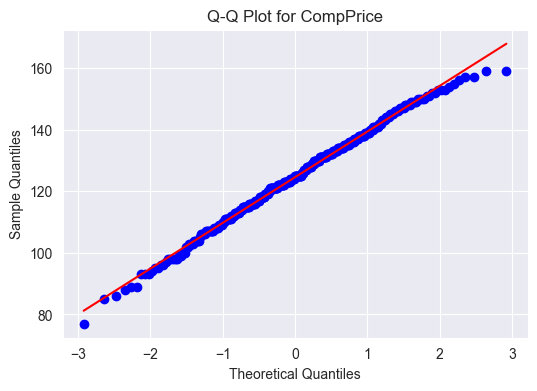

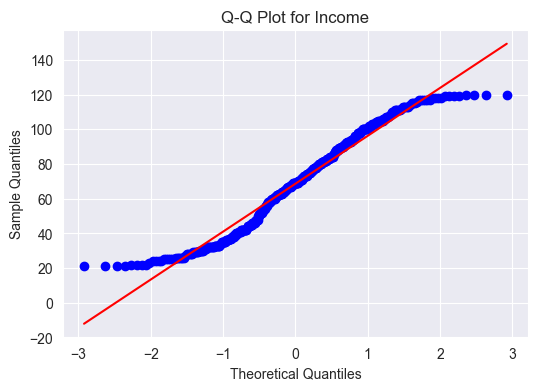

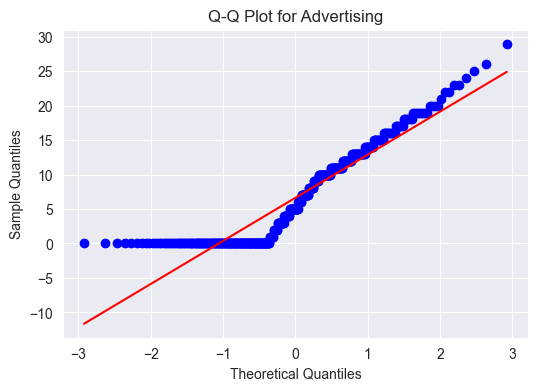

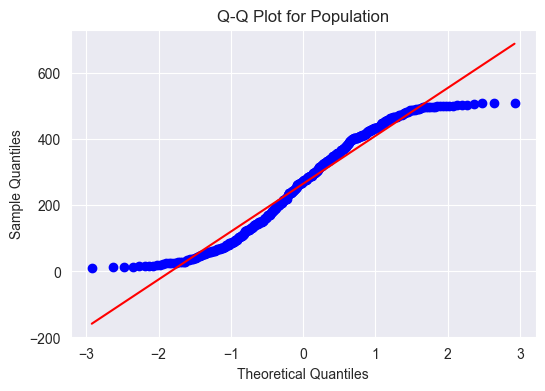

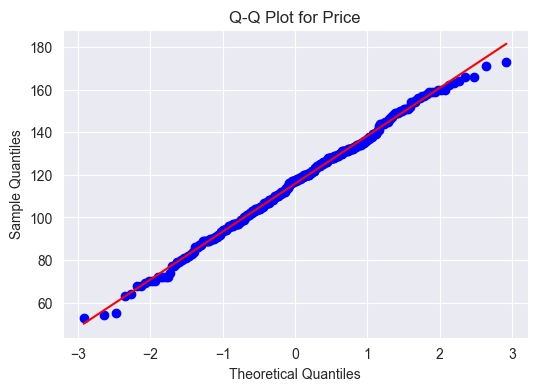

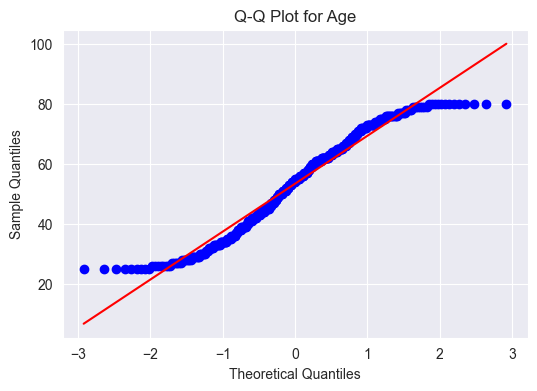

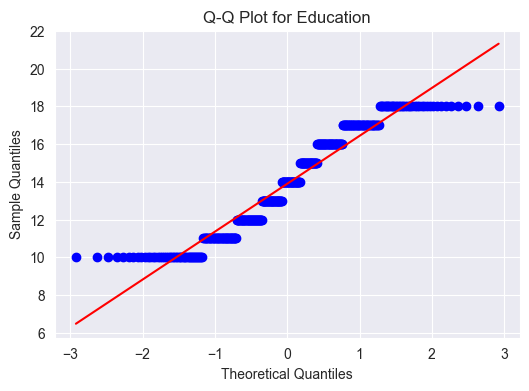

In [35]:
# Using Q-Q plot for checking the data distribution
# Create Q-Q plots for each variable in separate graphs
for col in cont_df2.columns:
    plt.figure(figsize=(6, 4))
    stats.probplot(cont_df2[col], dist="norm", plot=plt)
    plt.title(f"Q-Q Plot for {col}")
    plt.xlabel("Theoretical Quantiles")
    plt.ylabel("Sample Quantiles")
    plt.grid(True)
    plt.show()

## Most of the Q-Q plot shows that features are not normally distributed.
## Hence we can use Normalization for transformation. 

In [69]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the Normalization
min_max_scaler = MinMaxScaler()

# Fit and transform the data using standardization
normalized_data_minmax = min_max_scaler.fit_transform(cont_df2)


# Create a new DataFrame with the standardized data
norm_df = pd.DataFrame(normalized_data_minmax, columns = cont_df2.columns)

In [70]:
norm_df

,CompPrice,Income,Advertising,Population,Price,Age,Education
0,0.743902,0.525253,0.379310,0.533066,0.558333,0.309091,0.875
1,0.414634,0.272727,0.551724,0.501002,0.250000,0.727273,0.000
2,0.439024,0.141414,0.344828,0.519038,0.225000,0.618182,0.250
3,0.487805,0.797980,0.137931,0.913828,0.366667,0.545455,0.500
4,0.780488,0.434343,0.103448,0.661323,0.625000,0.236364,0.375
...,...,...,...,...,...,...,...
395,0.743902,0.878788,0.586207,0.386774,0.625000,0.145455,0.500
396,0.756098,0.020202,0.103448,0.054108,0.558333,0.545455,0.125
397,0.585366,0.050505,0.413793,0.717435,0.883333,0.272727,1.000
398,0.280488,0.585859,0.241379,0.549098,0.350000,0.454545,0.250


### Pre-processing of Training Categorical variable dataframe. 

In [38]:
cat_df.head(5)

,Urban,US,ShelveLoc,Sales
0,Yes,Yes,Bad,9.50
1,Yes,Yes,Good,11.22
2,Yes,Yes,Medium,10.06
3,Yes,Yes,Medium,7.40
4,Yes,No,Bad,4.15


In [40]:
# Replace 'desired_columns' with a list of column names for which you want to find unique values
desired_columns = ["Urban", "US", "ShelveLoc"]

# Create an empty dictionary to store unique values for each column
unique_values_dict = {}

# Loop through the desired columns and find unique values for each
for column in desired_columns:
    unique_values = cat_df[column].unique()
    unique_values_dict[column] = unique_values

In [42]:
unique_values_dict

{'Urban': array(['Yes', 'No'], dtype=object),
 'US': array(['Yes', 'No'], dtype=object),
 'ShelveLoc': array(['Bad', 'Good', 'Medium'], dtype=object)}

### Applying Label encoder to Urban column as it has only two categories.

In [43]:
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
encoder = LabelEncoder()

# Fit and transform the dataset
encoded_labels = encoder.fit_transform(cat_df["Urban"])

# Add encoded labels to the DataFrame
cat_df["Urban"] = encoded_labels

### Applying Label encoder to US column as it has only two categories.

In [44]:
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
encoder = LabelEncoder()

# Fit and transform the dataset
encoded_labels = encoder.fit_transform(cat_df["US"])

# Add encoded labels to the DataFrame
cat_df["US"] = encoded_labels

In [45]:
cat_df

,Urban,US,ShelveLoc,Sales
0,1,1,Bad,9.50
1,1,1,Good,11.22
2,1,1,Medium,10.06
3,1,1,Medium,7.40
4,1,0,Bad,4.15
...,...,...,...,...
395,1,1,Good,12.57
396,0,1,Medium,6.14
397,1,1,Medium,7.41
398,1,1,Bad,5.94


### Applying dummy variables on ShelveLoc column.

In [46]:
import pandas as pd

# Create dummy variables for the 'Category' column
dummy_df = pd.get_dummies(cat_df['ShelveLoc'], prefix='ShelveLoc', drop_first=True)

# Drop the original 'Category' column from the original DataFrame
cat_df.drop(columns=['ShelveLoc'], inplace=True)

# Concatenate the original DataFrame and the dummy DataFrame
cat_df = pd.concat([cat_df, dummy_df], axis=1)

In [47]:
cat_df

,Urban,US,Sales,ShelveLoc_Good,ShelveLoc_Medium
0,1,1,9.50,0,0
1,1,1,11.22,1,0
2,1,1,10.06,0,1
3,1,1,7.40,0,1
4,1,0,4.15,0,0
...,...,...,...,...,...
395,1,1,12.57,1,0
396,0,1,6.14,0,1
397,1,1,7.41,0,1
398,1,1,5.94,0,0


### Applying decision tree on sales column to convert from continuous variable to categorical variable.

In [60]:
import pandas as pd

# Manually define categories
custom_categories = ['Very_low','Low', 'Medium', 'High']

# Use pandas cut function with custom categories
cat_df['sales_cat'] = pd.cut(cat_df['Sales'], bins=4, labels=custom_categories)

In [62]:
cat_df.head(2)

,Urban,US,Sales,ShelveLoc_Good,ShelveLoc_Medium,sales_cat
0,1,1,9.50,0,0,Medium
1,1,1,11.22,1,0,Medium


In [63]:
# Drpping the Sales feature.
cat_df.drop(columns=['Sales'], inplace=True)

In [64]:
cat_df.head(2)

,Urban,US,ShelveLoc_Good,ShelveLoc_Medium,sales_cat
0,1,1,0,0,Medium
1,1,1,1,0,Medium


### Applying label encoder on sales_cat column the target variable.

In [114]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Create a LabelEncoder instance
label_encoder = LabelEncoder()

# Fit and transform the target column
cat_df['sales_cat'] = label_encoder.fit_transform(cat_df['sales_cat'])

In [115]:
cat_df.head(2)

,Urban,US,ShelveLoc_Good,ShelveLoc_Medium,sales_cat
0,1,1,0,0,2
1,1,1,1,0,2


### Mearging training normalized continuous variable dataframe and encoded dataframe. 

In [116]:
# Concatenate the original DataFrame and the encoded DataFrame
norm_final_df = pd.concat([norm_df, cat_df], axis=1)

In [117]:
norm_final_df

,CompPrice,Income,Advertising,Population,Price,Age,Education,Urban,US,ShelveLoc_Good,ShelveLoc_Medium,sales_cat
0,0.743902,0.525253,0.379310,0.533066,0.558333,0.309091,0.875,1,1,0,0,2
1,0.414634,0.272727,0.551724,0.501002,0.250000,0.727273,0.000,1,1,1,0,2
2,0.439024,0.141414,0.344828,0.519038,0.225000,0.618182,0.250,1,1,0,1,2
3,0.487805,0.797980,0.137931,0.913828,0.366667,0.545455,0.500,1,1,0,1,1
4,0.780488,0.434343,0.103448,0.661323,0.625000,0.236364,0.375,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
395,0.743902,0.878788,0.586207,0.386774,0.625000,0.145455,0.500,1,1,1,0,0
396,0.756098,0.020202,0.103448,0.054108,0.558333,0.545455,0.125,0,1,0,1,1
397,0.585366,0.050505,0.413793,0.717435,0.883333,0.272727,1.000,1,1,0,1,1
398,0.280488,0.585859,0.241379,0.549098,0.350000,0.454545,0.250,1,1,0,0,1


### Mearging original continuous variable dataframe and encoded dataframe. 

In [118]:
# Concatenate the original DataFrame and the encoded DataFrame
org_final_df = pd.concat([cont_df2, cat_df], axis=1)

In [119]:
org_final_df

,CompPrice,Income,Advertising,Population,Price,Age,Education,Urban,US,ShelveLoc_Good,ShelveLoc_Medium,sales_cat
0,138,73,11,276,120,42,17,1,1,0,0,2
1,111,48,16,260,83,65,10,1,1,1,0,2
2,113,35,10,269,80,59,12,1,1,0,1,2
3,117,100,4,466,97,55,14,1,1,0,1,1
4,141,64,3,340,128,38,13,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
395,138,108,17,203,128,33,14,1,1,1,0,0
396,139,23,3,37,120,55,11,0,1,0,1,1
397,125,26,12,368,159,40,18,1,1,0,1,1
398,100,79,7,284,95,50,12,1,1,0,0,1


# Model building

### Model building on normalized dataset.

In [135]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report

# Separate features (X) and target variable (y)
X = norm_final_df.drop('sales_cat', axis=1)
y = norm_final_df['sales_cat']

X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, random_state=42)

dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(X_train, y_train)

y_pred = dt_classifier.predict(X_test)

accuracy1 = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy1)
print("Classification Report:\n", report)


Accuracy: 0.5625
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.36      0.50        11
           1       0.65      0.59      0.62        37
           2       0.48      0.64      0.55        25
           3       0.38      0.43      0.40         7

    accuracy                           0.56        80
   macro avg       0.58      0.51      0.52        80
weighted avg       0.59      0.56      0.56        80



## Random search CV for model optimization. 

In [136]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier

# Define the hyperparameter space to search
param_dist = {
    'criterion': ['gini', 'entropy'],
    'max_depth': np.arange(0, 11),
    'min_samples_split': np.arange(0, 11),
    'min_samples_leaf': np.arange(0, 11),
}

# Initialize the Decision Tree classifier
dt_classifier = DecisionTreeClassifier()

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    dt_classifier, param_distributions=param_dist, n_iter=100, cv=5, random_state=42, n_jobs=-1
)

# Perform the random search
random_search.fit(X, y)

# Print the best hyperparameters
print("Best Hyperparameters:", random_search.best_params_)

# Print the best cross-validated score
print("Best Score (Cross-Validated Accuracy):", random_search.best_score_)


Best Hyperparameters: {'min_samples_split': 8, 'min_samples_leaf': 4, 'max_depth': 1, 'criterion': 'gini'}
Best Score (Cross-Validated Accuracy): 0.585


## Grid search CV for model optimization. 

In [137]:
from sklearn.datasets import load_iris
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': np.arange(1, 16),  # Range from 1 to 15 (inclusive)
    'min_samples_split': np.arange(2, 11),  # Range from 2 to 10 (inclusive)
    'min_samples_leaf': np.arange(1, 10),  # Range from 1 to 4 (inclusive)
}
# Initialize the Decision Tree classifier
dt_classifier = DecisionTreeClassifier(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(
    dt_classifier, param_grid=param_grid, cv=5, n_jobs=-1
)

# Perform the grid search
grid_search.fit(X, y)

# Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

# Print the best cross-validated score
print("Best Score (Cross-Validated Accuracy):", grid_search.best_score_)

Best Hyperparameters: {'criterion': 'gini', 'max_depth': 9, 'min_samples_leaf': 3, 'min_samples_split': 2}
Best Score (Cross-Validated Accuracy): 0.5900000000000001


## K-fold cross validation 

In [138]:
from sklearn.datasets import load_iris
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier

param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': np.arange(1, 16),  # Range from 1 to 15 (inclusive)
    'min_samples_split': np.arange(2, 11),  # Range from 2 to 10 (inclusive)
    'min_samples_leaf': np.arange(1, 10),  # Range from 1 to 4 (inclusive)
}
# Initialize the Decision Tree classifier
dt_classifier = DecisionTreeClassifier(random_state=42)

# Initialize GridSearchCV with k-fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(
    dt_classifier, param_grid=param_grid, cv=cv, n_jobs=-1, scoring='accuracy'
)

# Perform the grid search
grid_search.fit(X, y)

# Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

# Print the best cross-validated score
print("Best Score (Cross-Validated Accuracy):", grid_search.best_score_)


Best Hyperparameters: {'criterion': 'entropy', 'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best Score (Cross-Validated Accuracy): 0.6


# Final  model with optimum values.

In [139]:
from sklearn.tree import DecisionTreeClassifier

# Initialize a Decision Tree classifier with custom hyperparameters
final_model = DecisionTreeClassifier(
    criterion='entropy',
    max_depth=7,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42
)

final_model.fit(X_train, y_train)

y_pred = final_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:\n", report)


Accuracy: 0.525
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.27      0.43        11
           1       0.60      0.65      0.62        37
           2       0.46      0.52      0.49        25
           3       0.22      0.29      0.25         7

    accuracy                           0.53        80
   macro avg       0.57      0.43      0.45        80
weighted avg       0.58      0.53      0.52        80



## Here as we can see even though the accuracy value has been in the same range the precision value has reached 1. Hence it is a better model. 

## Visualization of Tree 

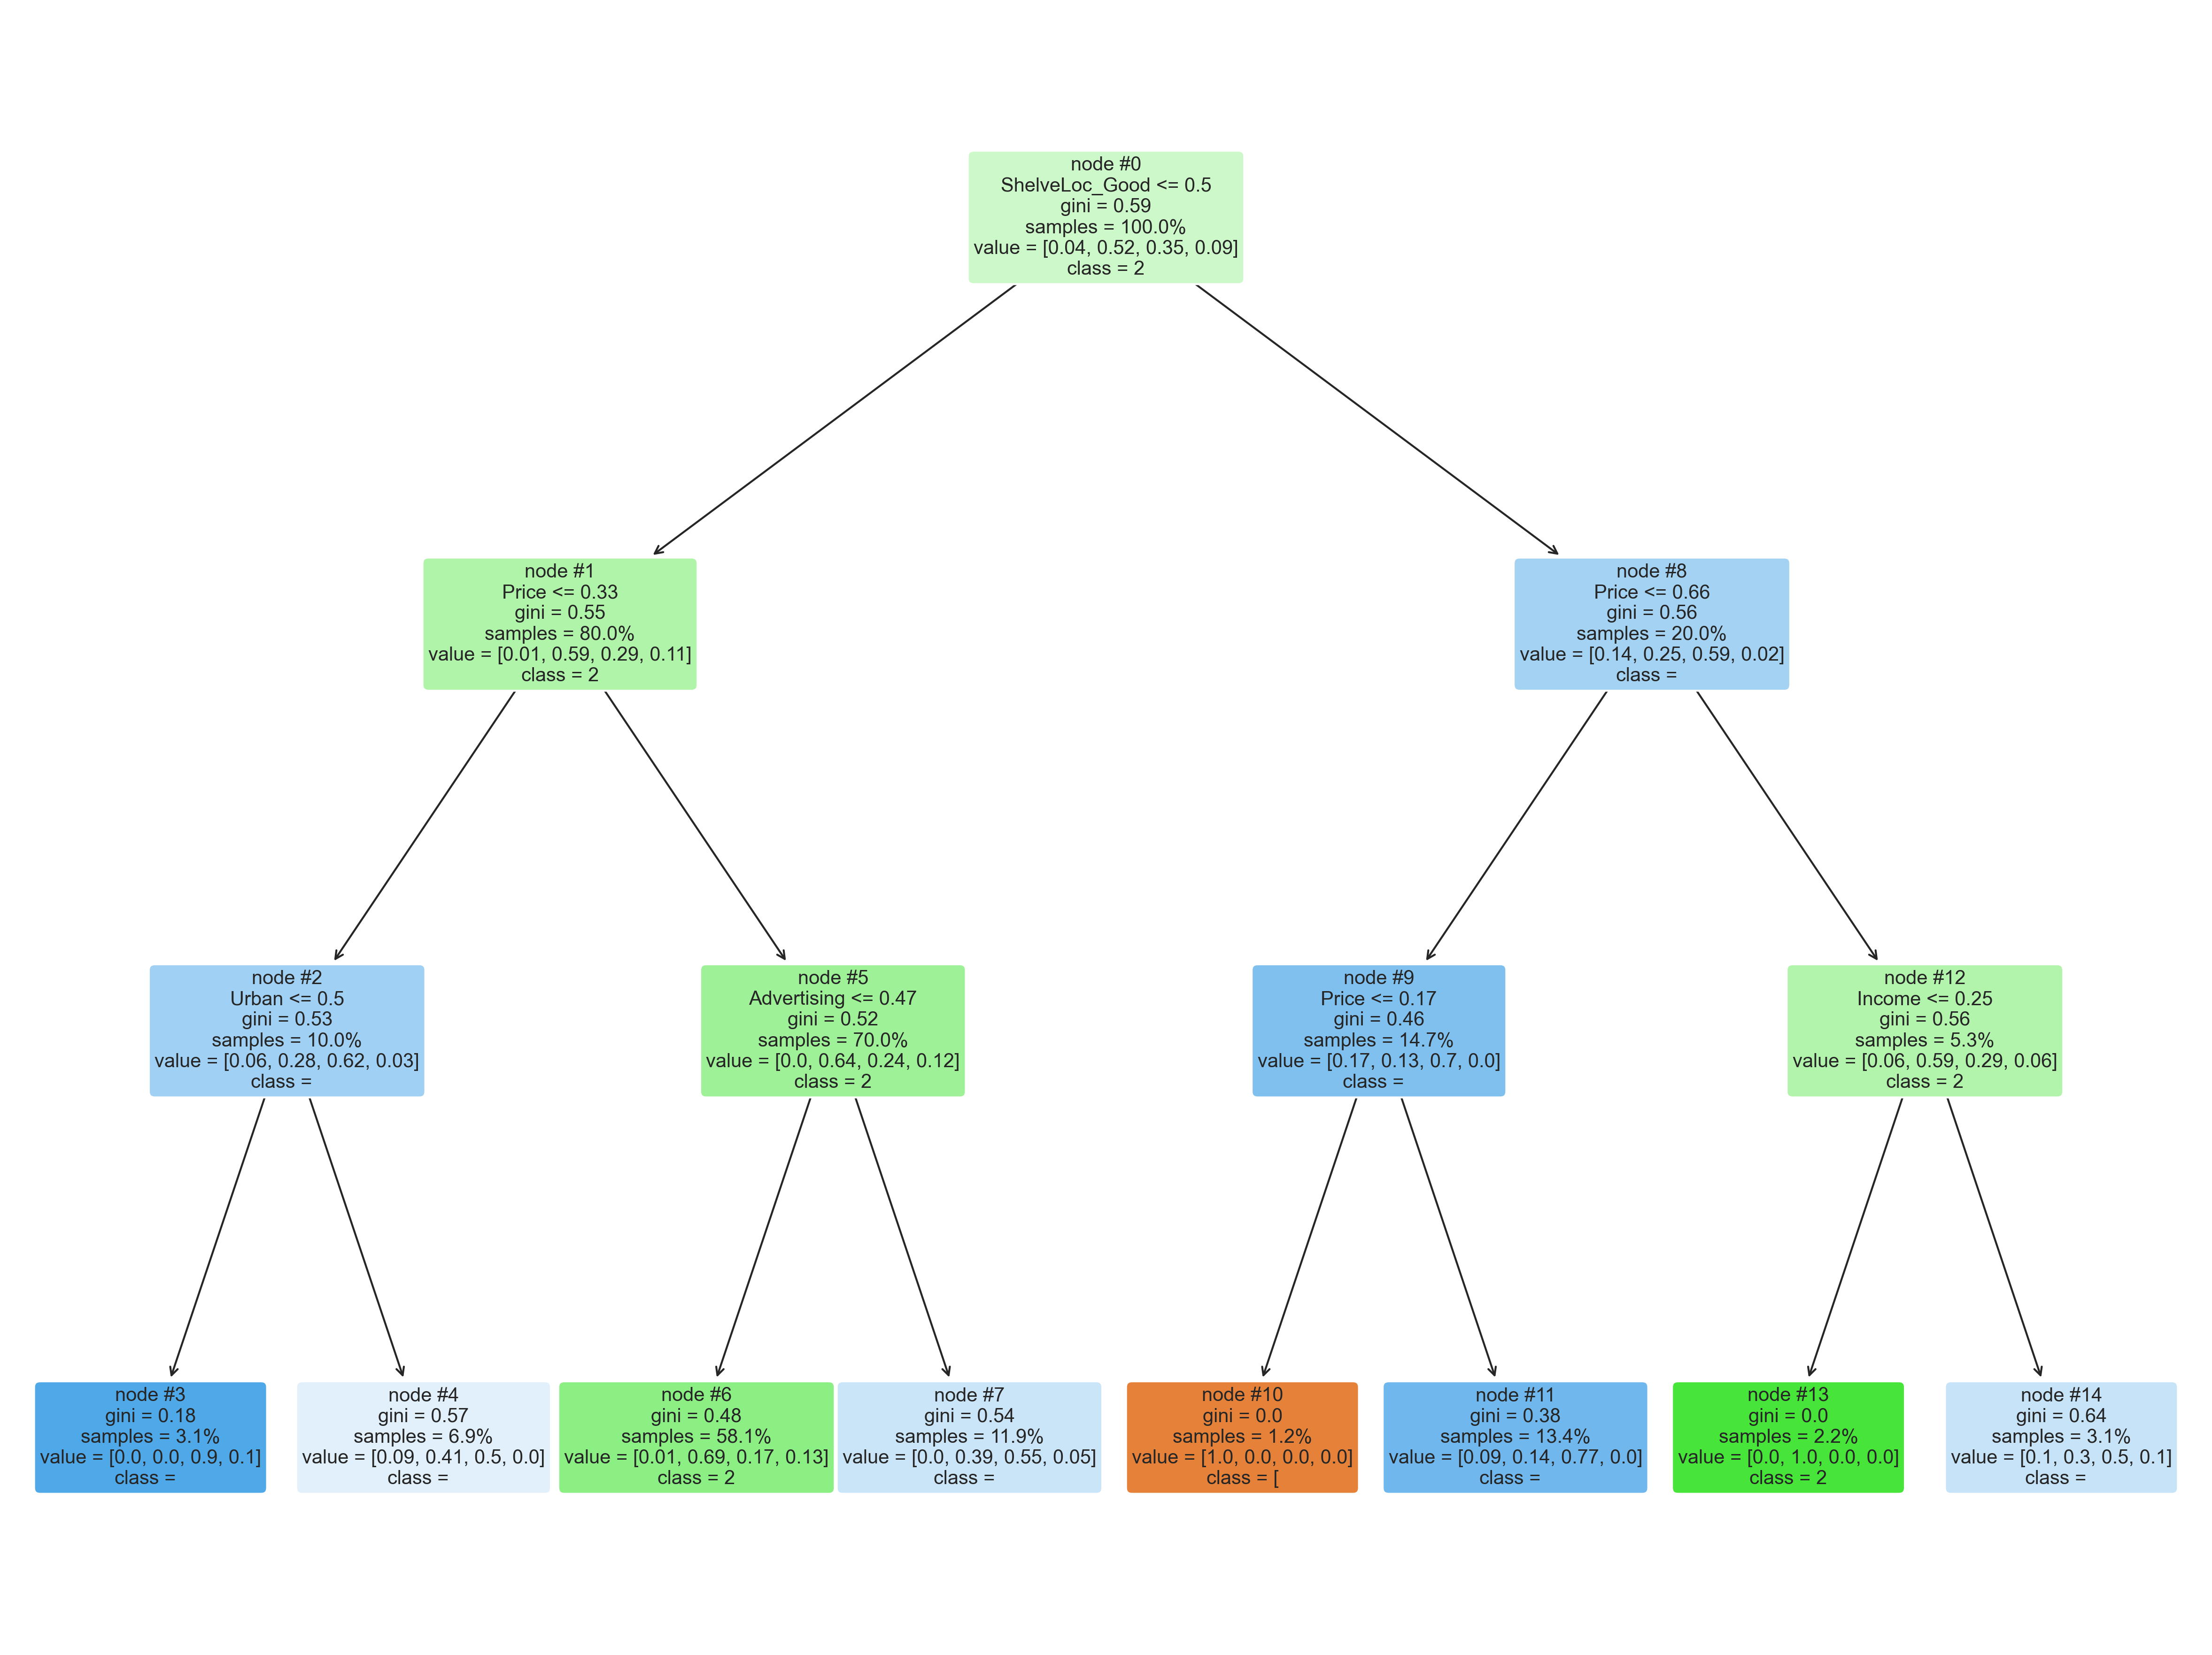

In [128]:
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt

# Initialize a Decision Tree classifier with custom hyperparameters
final_model = DecisionTreeClassifier(
    criterion='gini',
    max_depth=9,
    min_samples_split=2,
    min_samples_leaf=3,
    random_state=42
)

final_model.fit(X_train, y_train)

# Create a higher-resolution plot
plt.figure(figsize=(20, 15), dpi=300)

# Plot the decision tree with customized node attributes
tree.plot_tree(
    dt_classifier,
    filled=True,
    rounded=True,
    fontsize=10,  # Adjust the font size for node text
    node_ids=True,  # Show node IDs
    impurity=True,  # Show impurity values
    proportion=True,  # Show class proportions
    precision=2,  # Number of decimal places for values
    feature_names=X.columns,  # Replace with your feature names
    class_names=str(y.unique()),  # Replace with your class names
)

# Show the plot
plt.show()


### Confusion matrix for model accuracy.

In [132]:
# Confusion Matrix for the model accuracy
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test,y_pred)
print(confusion_matrix)

[[ 3  0  8  0]
 [ 0 24  7  6]
 [ 0 11 13  1]
 [ 0  5  0  2]]


### Classification report for model performance

In [133]:
#Classification report
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      0.27      0.43        11
           1       0.60      0.65      0.62        37
           2       0.46      0.52      0.49        25
           3       0.22      0.29      0.25         7

    accuracy                           0.53        80
   macro avg       0.57      0.43      0.45        80
weighted avg       0.58      0.53      0.52        80

